In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pylab

from scipy.optimize import curve_fit, leastsq

#pd.set_option('display.max_columns', 500)
sns.set_style('whitegrid')

In [2]:
df_cases_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", index_col=False)
df_deaths_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv", index_col=False)
df_recoveries_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv", index_col=False)

In [3]:
df_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,53,59,70,75,82,114,147,177,212,272
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,581,639,639,701,773,839,825,878,889,924
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,160,178,178,200,212,226,243,266,313,345
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,129,149,149,197,238,428,566,673,790,900


In [4]:
df_cases_grouped = df_cases_raw.groupby(by='Country/Region', as_index=False).agg('sum')
top_cases = df_cases_grouped.nlargest(10, df_cases_raw.columns[-1])['Country/Region']
print top_cases

30              China
73              Italy
69               Iran
133             Spain
57            Germany
146                US
53             France
79       Korea, South
138       Switzerland
149    United Kingdom
Name: Country/Region, dtype: object


In [5]:
def preprocess_frame(df):
    df = df.groupby(by='Country/Region', as_index=False).agg('sum')
    df = df.drop(['Lat', 'Long'], 1)
    df = df.set_index('Country/Region').T
    df['Date'] = df.index
    df.insert(0, 'Day', range(0, len(df)))
    df["notChina"] = df.drop(['Day', 'China', 'Date'], axis=1).sum(axis=1)
    return df

df_cases = preprocess_frame(df_cases_raw)
df_deaths = preprocess_frame(df_deaths_raw)
df_recoveries = preprocess_frame(df_recoveries_raw)

In [6]:
def shift_to_day_zero(df, df_reference):
    for key in df.columns:
        if key!= 'Date' and key!='Day' :
            if df_reference[key].sum()>0:
                df[key] = df[key].shift(-df_reference['Day'][df_reference[key]>0].iloc[0])
    

df_cases_reference = df_cases.copy()
shift_to_day_zero(df_cases, df_cases_reference)
shift_to_day_zero(df_deaths, df_cases_reference)
shift_to_day_zero(df_recoveries, df_cases_reference)

<IPython.core.display.Javascript object>


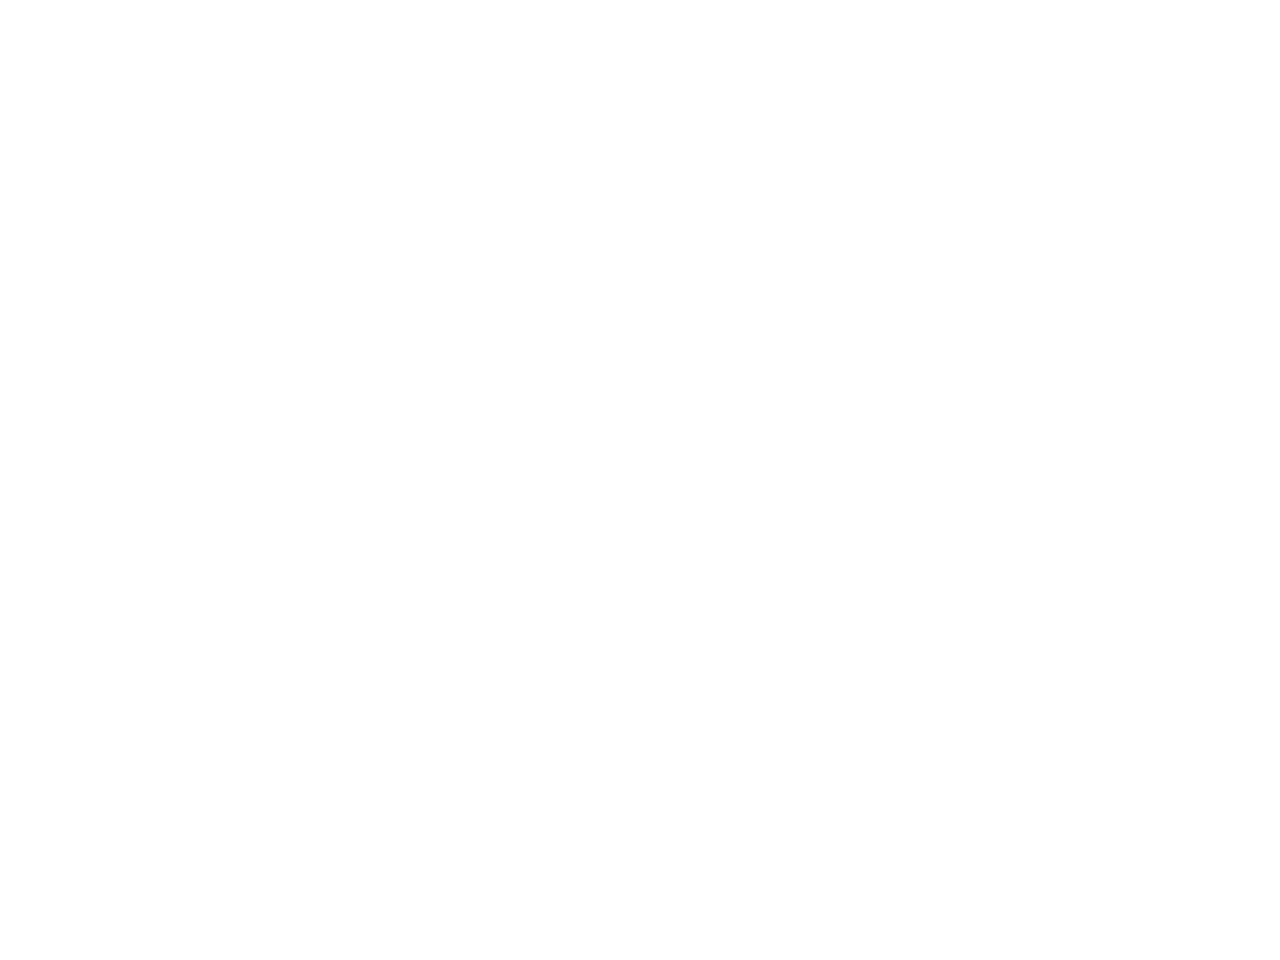

In [7]:
%matplotlib notebook

countries = top_cases
def plot_confirmed_cases(df, countries):
    g = sns.lineplot(df['Day'], df['Greece'], label='Greece')
    #sns.lineplot(df['Day'], df['notChina'], label='notChina')
    for country in countries:
        sns.lineplot(df['Day'], df[country], label=country)
    g.set(xlabel='Days since first confirmed case', ylabel='Confirmed cases')
    g.set_yscale("log")
    plt.legend()
 
plot_confirmed_cases(df_cases, countries)

<IPython.core.display.Javascript object>


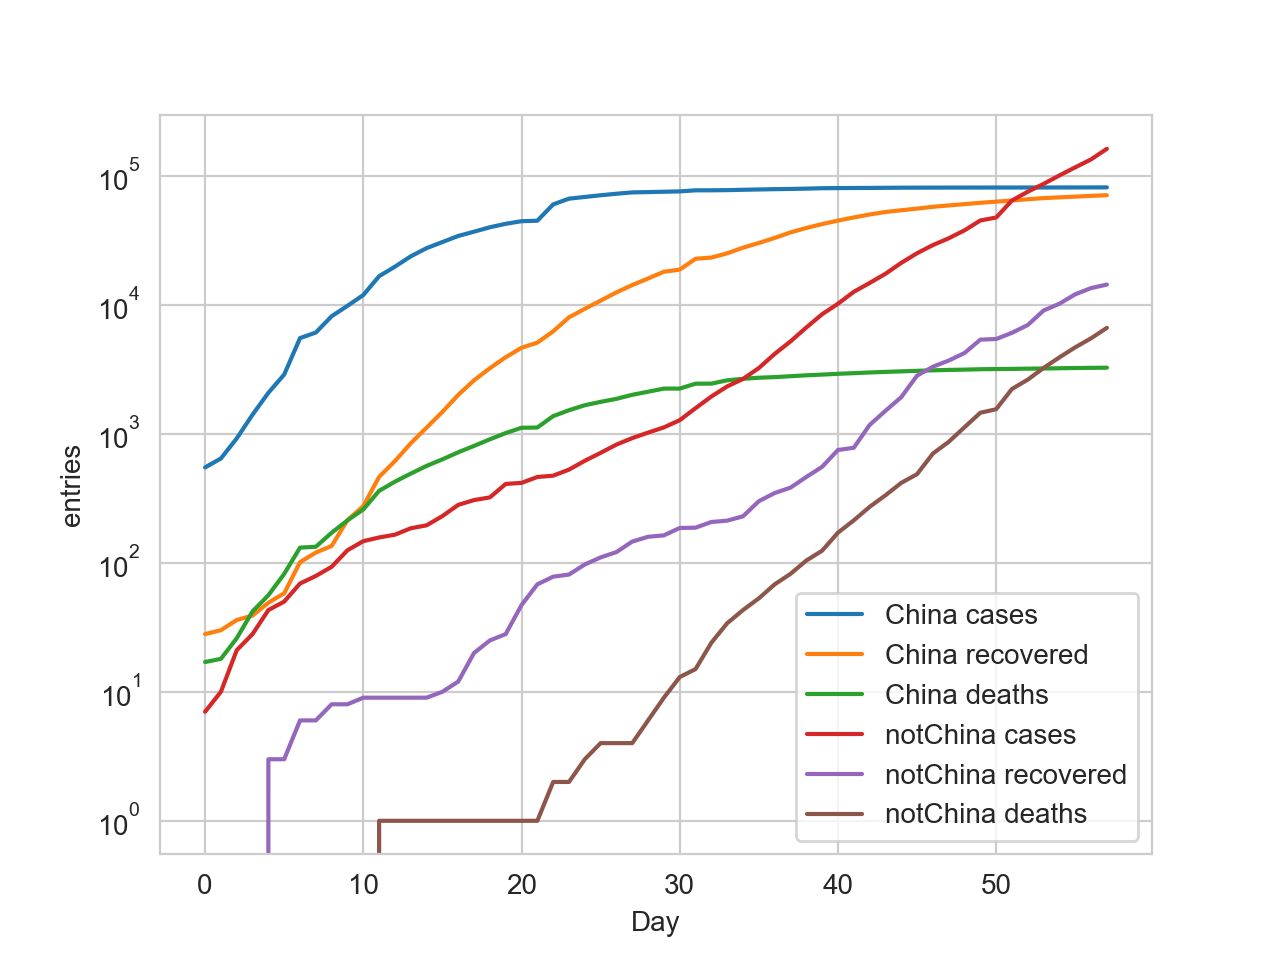

In [13]:
%matplotlib notebook

def plot_case_death_recovery(country):
    g = sns.lineplot(df_cases['Day'], df_cases[country], label=country+' cases')
    sns.lineplot(df_recoveries['Day'], df_recoveries[country], label=country+' recovered')
    sns.lineplot(df_deaths['Day'], df_deaths[country], label=country+' deaths')
    g.set(ylabel='entries')
    g.set_yscale("log")
    plt.legend()

plot_case_death_recovery('China')
plot_case_death_recovery('notChina')

Fit:
x0 = 17.558393292
k  = 0.214531830505
a  = 82377.8372637
c  = -1322.71970238
Asymptotes are -1322.71970238 and 81055.1175613
[  1.75583933e+01   2.14531831e-01   8.23778373e+04  -1.32271970e+03]


<IPython.core.display.Javascript object>


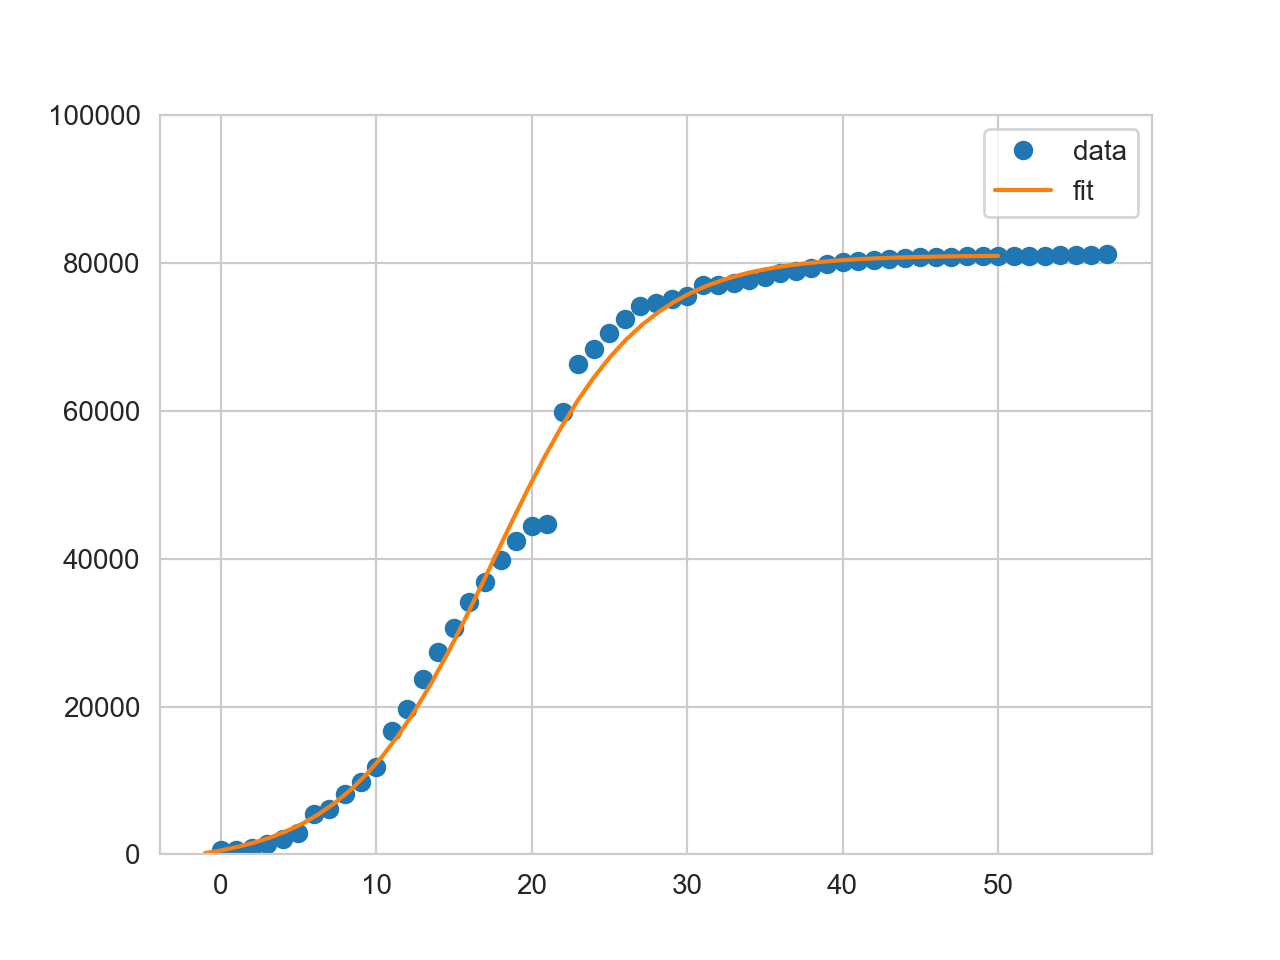

In [12]:
%matplotlib notebook

def sigmoid(x, x0, k, a, c):
     y = a / (1 + np.exp(-k*(x-x0))) + c
     return y

xdata, ydata = df_cases['Day'], df_cases['China']
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=(1.0, -1.0, 1.0, 0.0))
print "Fit:"
print "x0 =", popt[0]
print "k  =", popt[1]
print "a  =", popt[2]
print "c  =", popt[3]
print "Asymptotes are", popt[3], "and", popt[3] + popt[2] 

print popt

x = np.linspace(-1, 50, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 100000)
pylab.legend(loc='best')
pylab.show()

<IPython.core.display.Javascript object>


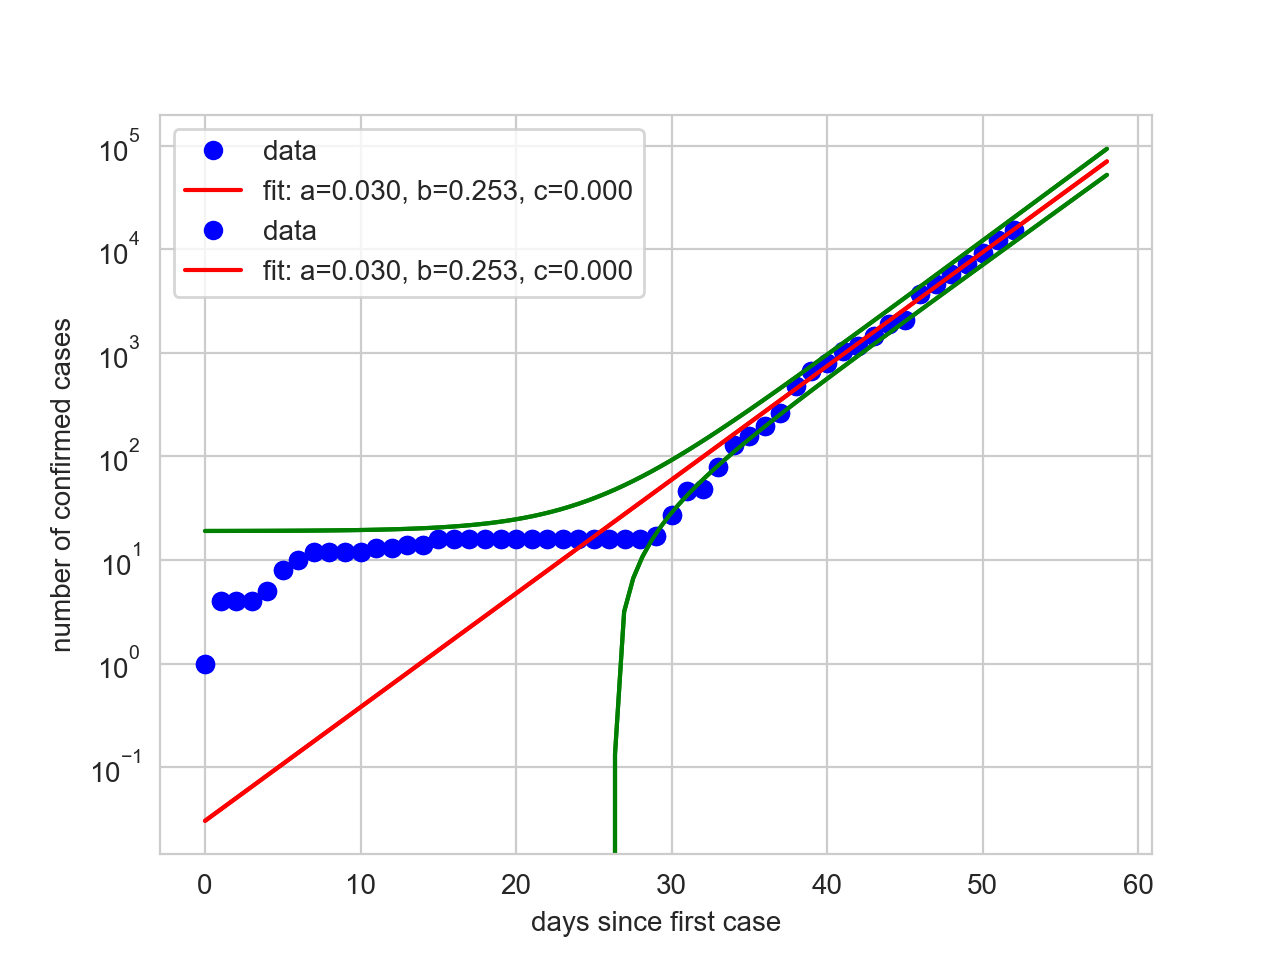

[  3.02851466e-02   2.52823384e-01   2.44050999e-15]
[[  1.66799962e-05  -1.08207803e-05  -3.36828644e-02]
 [ -1.08207803e-05   7.02982351e-06   2.12099478e-02]
 [ -3.36828644e-02   2.12099478e-02   3.62512317e+02]]


In [17]:
%matplotlib notebook

def func(x, a, b, c):
    return a * np.exp(b * x) + c

def fit_cases_data(country, func):
    df = df_cases.copy()
    firstday = 0
    lastday = df[country].dropna().shape[0]

    xdata = df['Day'][(df['Day']>=firstday) & (df['Day']<lastday)]
    ydata = df[country][(df['Day']>=firstday) & (df['Day']<lastday)]
    
    plt.plot(xdata, ydata, 'bo', label='data')

    popt, pcov = curve_fit(func, xdata, ydata, [1,0.1,0.1], bounds=[[-100, -100, 0],[100, 100, 100]])
    print(popt)
    print(pcov)
    x = np.linspace(firstday, lastday+5 , 100)
    plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

    perr=np.sqrt(np.diag(pcov)) #standard errors
    plt.plot(x,func(x, *popt+perr), 'g')
    plt.plot(x,func(x, *popt-perr), 'g')

    plt.xlabel('days since first case')
    plt.ylabel('number of confirmed cases')
    plt.legend()
    plt.yscale('log')
    plt.show()

country = 'Germany'

#df = df_deaths.copy()
df = df_cases.copy()
#df = df_recoveries.copy()

firstday = 0
lastday = df[country].dropna().shape[0]

xdata = df['Day'][(df['Day']>=firstday) & (df['Day']<lastday)]
ydata = df[country][(df['Day']>=firstday) & (df['Day']<lastday)]

plt.plot(xdata, ydata, 'bo', label='data')

popt, pcov = curve_fit(func, xdata, ydata, [1,0.1,0.1], bounds=[[-100, -100, 0],[100, 100, 100]])
print(popt)
print(pcov)
x = np.linspace(firstday, lastday+5 , 100)
plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

perr=np.sqrt(np.diag(pcov)) #standard errors
plt.plot(x,func(x, *popt+perr), 'g')
plt.plot(x,func(x, *popt-perr), 'g')

plt.xlabel('days since first case')
plt.ylabel('number of confirmed cases')
plt.legend()
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


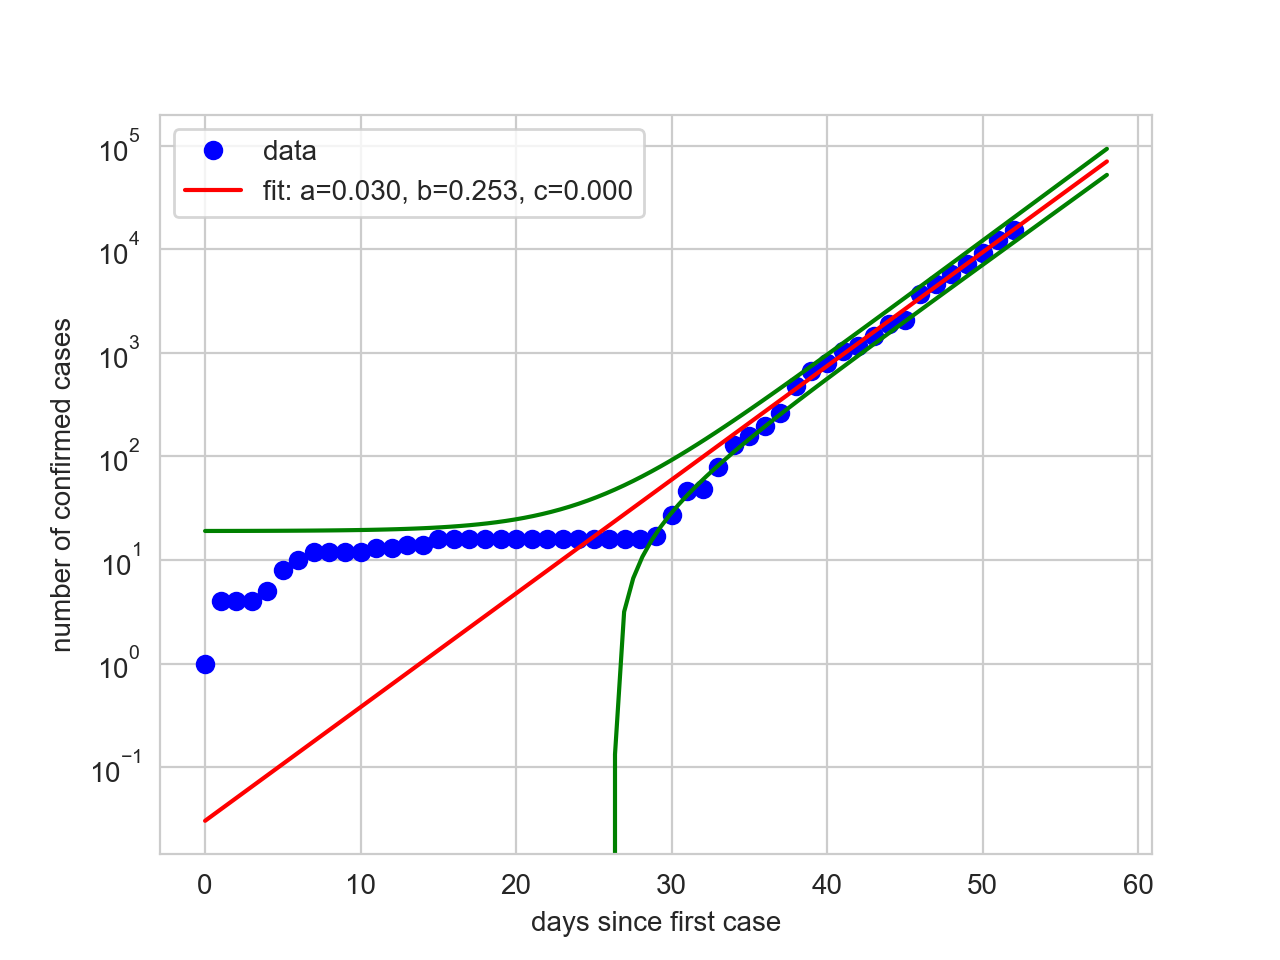

[  3.02851466e-02   2.52823384e-01   2.44050999e-15]
[[  1.66799962e-05  -1.08207803e-05  -3.36828644e-02]
 [ -1.08207803e-05   7.02982351e-06   2.12099478e-02]
 [ -3.36828644e-02   2.12099478e-02   3.62512317e+02]]


In [19]:
%matplotlib notebook

fit_cases_data("Germany", func)